In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Cargar imagen
image_path = '../data/imgs/001.jpg'  # <- Cambiá esto por la ruta real
image = cv2.imread(image_path)

# Aumentar saturación y contraste
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)

# Ajustes: aumentar saturación y valor (brillo)
image_hsv[..., 1] *= 1.5  # saturación
image_hsv[..., 2] *= 1.2  # brillo

# Limitar valores al rango válido
image_hsv = np.clip(image_hsv, 0, 255).astype(np.uint8)

# Convertir de nuevo a RGB
image_bgr_enhanced = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)
image_rgb = cv2.cvtColor(image_bgr_enhanced, cv2.COLOR_BGR2RGB)

# Cargar modelo SAM
sam_checkpoint = "../checkpoints/sam_vit_h_4b8939.pth"  # <- Asegurate de tener este archivo
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)


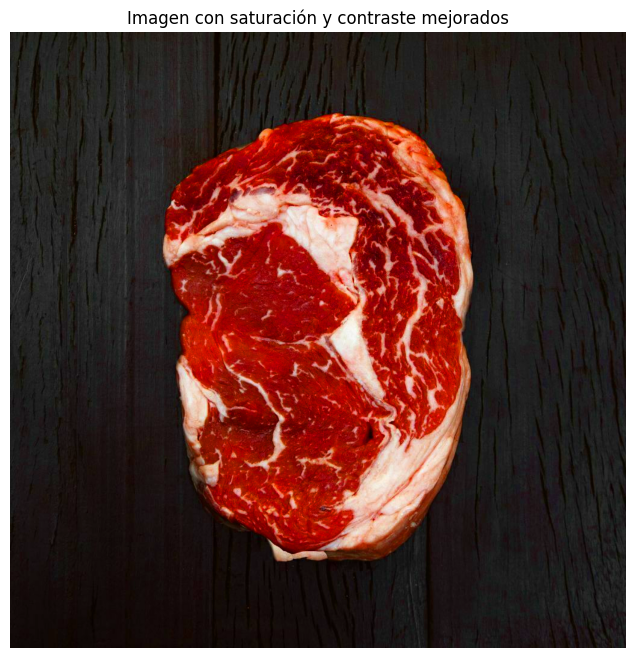

In [2]:
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.title("Imagen con saturación y contraste mejorados")
plt.axis("off")
plt.show()


In [3]:
clicked_points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(clicked_points) < 6:
        clicked_points.append((x, y))
        print(f"Clic {len(clicked_points)} registrado en: ({x}, {y})")

cv2.imshow("Seleccionar 3 puntos de grasa y 3 de carne", cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
cv2.setMouseCallback("Seleccionar 3 puntos de grasa y 3 de carne", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(clicked_points) < 6:
    raise ValueError("Necesitás 3 clics para grasa y 3 para carne (total 6).")

# Separar los puntos
grasa_points = clicked_points[:3]
carne_points = clicked_points[3:]

# Preparar puntos y etiquetas
input_points = np.array(grasa_points + carne_points)
input_labels = np.array([1]*6)  # Todos foreground

# Predecir con SAM
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True
)

# Elegir las mejores máscaras (puede probar con distintas combinaciones si querés más precisión)
mask_grasa = masks[0]
mask_carne = masks[1]

# Evitar superposición
mask_carne = np.logical_and(mask_carne, np.logical_not(mask_grasa))



Clic 1 registrado en: (642, 756)
Clic 2 registrado en: (520, 346)
Clic 3 registrado en: (304, 610)
Clic 4 registrado en: (404, 430)
Clic 5 registrado en: (498, 670)
Clic 6 registrado en: (718, 505)


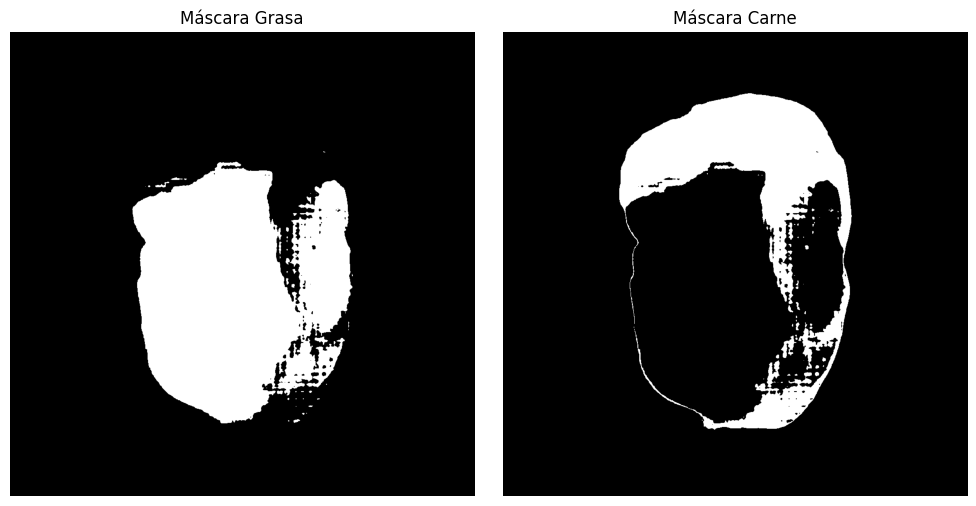

In [4]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask_grasa, cmap="gray")
plt.title("Máscara Grasa")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_carne, cmap="gray")
plt.title("Máscara Carne")
plt.axis("off")

plt.tight_layout()
plt.show()



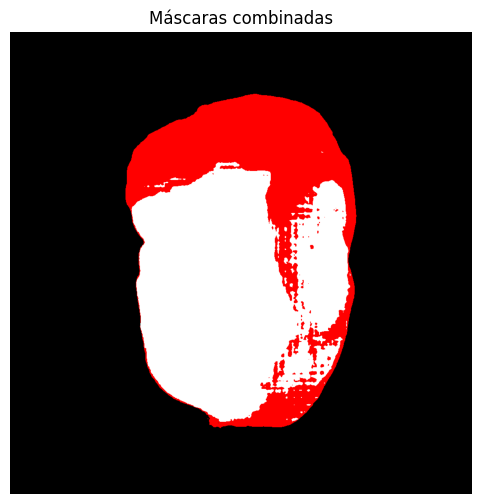

In [5]:
mask_comb = np.zeros((*mask_grasa.shape, 3), dtype=np.uint8)
mask_comb[mask_grasa] = [255, 255, 255]  # grasa -> blanco
mask_comb[mask_carne] = [255, 0, 0]      # carne -> rojo

plt.figure(figsize=(6, 6))
plt.imshow(mask_comb)
plt.title("Máscaras combinadas")
plt.axis("off")
plt.show()
